# Dissociation curve of the H$_2$O + HO$^-$ dimer without Constrained DFT

This notebook aims at presenting the case of a dimer that looks like the water dimer of another notebook, the difference being that an hydrogen atom is removed from one water molecule and an extra electron is added to the system, so that the number of electrons is the same as for the water dimer.

The calculations are very similar to the water dimer case, except that there is this extra electron. The cubic BigDFT calculations are the reference, and we compare the results obtained using linear BigDFT with the fragment approach while varying *nbasis* (which is the number of support functions per atom) to increase the number of degrees of freedom.

Regarding the water molecule, the templates created while studying the water dimer can be reused, therefore avoiding some calculations. In constrast, two different templates are computed for the hydroxide molecule: a template consisting of the hydroxide molecule (with the addition of an electron) while the other template is just the OH radical (without the addition of an electron). Both templates give the same number of support functions, which is five. We will finally compare the dissociation curves obtained using the fragment approach with both templates (an electron being added to the system).

In another notebook, we will compare the dissociation curves obtained here with the one obtained while using the constrained DFT on top of the fragment calculation, to ensure that the extra electron to remain in the vicinity of the OH molecule. 

**Import modules, classes and functions.**

In [1]:
from __future__ import print_function
import os
import sys
import subprocess
import shutil
import tarfile
import numpy as np
from futile.Utils import find_files
try:
    from BigDFT import Logfiles as lf
except ImportError:
    sys.path.append('/Users/maximemoriniere/post-doc/bigdft/bigdft/bigdft/src/python')
    from BigDFT import Logfiles as lf
import matplotlib.pyplot as plt

**Extract tarfiles to avoid re-running some calculations.**

One tarfile contains the templates used throughout this notebook, while the other contains the files related to the different dissociation curves that will be computed.

In [2]:
# Extract the archive containing the templates, if it exists
tartemplate = "templates_H2O_HO-.tgz"
if os.path.exists(tartemplate):
    print("Extract {} to avoid calculating the templates.".format(tartemplate))
    with tarfile.open(tartemplate,"r:bz2") as tar:
        tar.extractall()
        
# Extract the output files from an archive, if it exists
tarname = 'H2O_HO-.tgz'
if os.path.exists(tarname):
    print("Extract {} to avoid calculating every point of the dissociation curves.".format(tarname))
    with tarfile.open(tarname,"r:bz2") as tar:
        tar.extractall()

Extract templates_H2O_HO-.tgz to avoid calculating the templates.
Extract H2O_HO-.tgz to avoid calculating every point of the dissociation curves.


**Initialize some variables to get a clean tree of folders.**

In [3]:
# Path leading to the current folder
start_path = os.getcwd() 

# Templates folder
templates_folder = "templates" # Name
templates_path = start_path+"/"+templates_folder # Path leading to it
if not os.path.exists(templates_folder): os.mkdir(templates_folder)

# Dimer folder, different from the water dimer case
dimer_folder = "H2O_HO-" # Name
dimer_path = start_path+"/"+dimer_folder # Path leading to it
if not os.path.exists(dimer_folder): os.mkdir(dimer_folder)

**Define the BigDFT variable allowing to run BigDFT from the present notebook**

In [4]:
BigDFT = os.environ["BIGDFT_ROOT"]+"/bigdft"
if not os.path.exists(BigDFT):
    BigDFT = "/Users/maximemoriniere/post-doc/bigdft/bigdft/build/bigdft/src/bigdft"
os.environ["OMP_NUM_THREADS"]="4" # Depends on your computer (compiled with OpenMP)

## Templates calculations

We first want to compute the OH and OH$^-$ templates. To that end, we need to define the posinp file for the oh structure. We do this by taking a water dimer posinp file, focusing on the second water molecule, and remove one hydrogen atom from it (we could also remove the other hydrogen atom, or one hydrogen atom of the other water molecule and compare the results, but this goes beyond the scope of this notebook). 

We also define a function for the yaml input file, taking the values of *nbasis* for both type of atoms and a boolean named charged as argument(if charged is set to True, an extra electron is added, otherwise no electron is added; its default value is set to False).

In [5]:
ho_xyz = """\
2 angstroemd0
free
O             0.000000                 -0.003706000000            0.113495000000
H             0.296831                  0.762122000000           -0.351887000000"""

def ho_yaml(On=4, Hn=1, charged=False):
    if charged:
        qcharge_yaml = """
   qcharge: -1"""
    else:
        qcharge_yaml = """"""
    dft_yaml = """\
 import: linear
 dft:
   hgrids: 0.25
   rmult: [5.0, 7.0]
   inputpsiid: linear
   ixc: LDA (ABINIT)"""
    lin_yaml = """
 lin_general:
   output_wf: 1
   output_mat: 11
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0""".format(On=On, Hn=Hn)
    return dft_yaml + qcharge_yaml + lin_yaml

print(ho_yaml())
#print(ho_yaml(charged=True))

 import: linear
 dft:
   hgrids: 0.25
   rmult: [5.0, 7.0]
   inputpsiid: linear
   ixc: LDA (ABINIT)
 lin_general:
   output_wf: 1
   output_mat: 11
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: 4
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: 1
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0


Now that the input files for the templates, let us define a function ```run_bigdft``` that runs a BigDFT calculation only if it was not already computed (it also checks, for later fragment calculations, that the templates required to run the fragment calculation were already calculated using the ```collect_templates_data``` function, and copy this data in an appropriate folder)

In [6]:
# Define the functions allowing to run a BigDFT calculation
def collect_templates_data(input_name, templates_dir):
    """
    Function collecting the data of the templates required by the 
    input file input_name. Symbolic links to the input files 
    of the templates and a copy of the data-template folder is done. 
    The path to the templates data is given by templates_dir.

    :param input_name: Name of the input file.
    :type input_name: str
    :param templates_dir: Path to the templates.
    :type templates_dir: str
    """
    from futile import Yaml
    
    # Read the input file to get the names of the required templates
    input_file = Yaml.yaml.load(open(input_name, 'r').read())
    templates = [template for template in input_file['frag'] 
                 if template != 'constrained_dft'] 
    
    # Raise an error if a required template is missing from templates_dir
    if templates_dir is None:
        raise ValueError("A value should be given to templates_dir.")
        
    # Find if some templates are missing in the templates folder
    missing_templates = [template for template in templates \
                         if any([f not in os.listdir(templates_dir) \
                                 for f in ['data-'+template, template+".yaml", template+".xyz"]])]
    if missing_templates != []:
        raise ValueError("Missing template(s): {}".format(missing_templates))
        
    # Create ang go to a folder containing the data of all the templates
    data_folder = 'data-'+input_name[:-5]
    if data_folder not in os.listdir(os.getcwd()): os.mkdir(data_folder)
    os.chdir(data_folder)
    
    # Create the needed symlinks: data folder, and input and posinp files
    for template in templates:
        # Create the symlink to the template input files
        for f in [template+".yaml", template+".xyz"]:
            if f in os.listdir(os.getcwd()):
                os.remove(f)
            os.symlink(templates_path+"/"+f, f)
        # Copy the whole data-template folder
        data_template = 'data-'+template
        shutil.copytree(templates_path+"/"+data_template, data_template)
    
    # Don't forget to go back to the previous folder
    os.chdir("..")


def run_bigdft(yaml, xyz, prefix=None, templates_dir=None):
    """
    This function runs a bigdft calculation if it was not already performed.
    
    :param prefix: Prefix of the calculation to define the input files.
    :type prefix: str
    :param yaml: Content of the input file
    :type yaml: str
    :param xyz: Content of the posinp file
    :type xyz: str
    :param templates_dir: For fragment calculation : path to the templates 
                          (optional, default to None).
    :type templates_dir: str
    """
    # Initialise some variables
    if prefix is not None:
        input_name  = prefix+".yaml"    # input file name
        output_name = "log-"+input_name # output file name
        posinp_name = prefix+".xyz"     # posinp file name
        command = [BigDFT, prefix]
    else:
        input_name  = "input.yaml" # input file name
        output_name = "log.yaml"   # output file name
        posinp_name = "posinp.xyz" # posinp file name
        command = [BigDFT]
        
    # Check that the calculation was not already done
    if not os.path.exists(output_name):
        # Write the input file
        open(input_name, "w").write(yaml)
        # Collect the data required for a fragment calculation
        if " frag:" in yaml:
            collect_templates_data(input_name, templates_dir)
        # Write the posinp file
        open(posinp_name, "w").write(xyz)
        # Launch the calculation
        print(command, "...")
        run = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out, err = run.communicate()
        print(out)
    else:
        print("Logfile {} already exists!".format(output_name))

**We assume that you already performed the water dimer tutorial, so that the templates folder already exists. If this is note the case, in order not to repeat ourselves and for the readability of this notebook, we ask you to run the templates calculation of the water dimer tutorial.**

We therefore move on to the HO$^-$ and HO template calculation. We only have to go to the templates folder and perform both templates calculation. Let us start with the HO template:

In [7]:
# Go to the templates folder
os.chdir(templates_path)

# Run the template of the oh molecule
run_bigdft(ho_yaml(), ho_xyz, prefix="ho")

Logfile log-ho.yaml already exists!


Finally, let us perform the HO- template calculation

In [8]:
run_bigdft(ho_yaml(charged=True), ho_xyz, prefix="ho-")

Logfile log-ho-.yaml already exists!


## Fragment calculations

We can now run the fragment calculations using the different templates, and vary the distances between the two fragments. 

Let us start by defining the input files:

In [9]:
def dimer_xyz(d):
    x1 = d
    x2 = d + 0.296831000000
    d_xyz = """\
5 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             {0:14.12f}           -0.003706000000            0.113495000000
H             {1:14.12f}            0.762122000000           -0.351887000000"""
    return d_xyz.format(x1,x2)

def dimer_yaml(frag_names=["h2o", "ho"], On=4, Hn=1):
    return """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
   qcharge: -1
 lin_general:
   nit: 1
   kernel_restart_mode: kernel
   output_wf: 1
   output_mat: 1
   output_coeff: 1
   calc_dipole: Yes
   subspace_diag: Yes
 lin_basis:
   nit: 1
 lin_kernel:
   nit: [20,100]
   alphamix: 0.3
   rpnrm_cv: 1.0E-010
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
 frag:
   {name[0]}:
   - 1
   {name[1]}:
   - 2""".format(name=frag_names, On=On, Hn=Hn)

print(dimer_yaml())

 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
   qcharge: -1
 lin_general:
   nit: 1
   kernel_restart_mode: kernel
   output_wf: 1
   output_mat: 1
   output_coeff: 1
   calc_dipole: Yes
   subspace_diag: Yes
 lin_basis:
   nit: 1
 lin_kernel:
   nit: [20,100]
   alphamix: 0.3
   rpnrm_cv: 1.0E-010
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: 4
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: 1
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
 frag:
   h2o:
   - 1
   ho:
   - 2


We now define the ```run_setup``` function to run BigDFT for a set of distances between the two water molecules. This allows to get a clean folder tree: for each distance, a folder is created, containg the input, output and templates files. All these distance folders are placed in a folder that is specific of the the setup.

In [10]:
def run_setup(setup_folder, distances, yaml, xyz_func, templates_dir=None):
    """
    Function that creates all the folders and files for a given setup.
    A setup is defined by a folder name, created to store all the results
    obtained using a given yaml file but for different distances.
    It loops over all the distances to create a folder for each distance
    and then is nothing but a wrapper over the run_bigdft method
    """
    # - Create and go to the setup folder
    if setup_folder not in os.listdir(os.getcwd()): os.mkdir(setup_folder)
    os.chdir(setup_folder)
    
    # - Loop over the distances 
    #  (Both finally are here to make sure that the os.chdir("..") command
    #   is performed even if there is an interruption or an error.)
    prefix = "dimer"
    try:
        for d in dists:
            print("{}; dist={}".format(setup_folder, d))
            # - Create and go to a subfolder for the current distance
            subfolder = prefix+"_"+str(d)
            if subfolder not in os.listdir(os.getcwd()): os.mkdir(subfolder)
            os.chdir(subfolder)
            # - Run the calculation
            try:
                run_bigdft(yaml, xyz_func(d), prefix=prefix, \
                           templates_dir=templates_dir)
            finally:
                # This "finally" forces to go back to the dimer folder
                # if the BigDFT run is not completed.
                os.chdir("..")
    finally:
        # This "finally" forces to go back to the dimer folder
        # if the loop over the distances is not completed.
        os.chdir("..")

Now, we just need to go to the dimer folder and run the calculations for the different setups, starting with the one involving the HO template:

In [11]:
# Go to the dimer folder
os.chdir(dimer_path)

# Array of distances
dists = np.append(np.arange(1.3, 2.5, 0.1), np.arange(2.5, 5.5, 0.5))

# Run the first setup
run_setup("ho_1-4", dists, dimer_yaml(frag_names=["h2o", "ho"]), \
          dimer_xyz, templates_dir=templates_path)

ho_1-4; dist=1.3
Logfile log-dimer.yaml already exists!
ho_1-4; dist=1.4
Logfile log-dimer.yaml already exists!
ho_1-4; dist=1.5
Logfile log-dimer.yaml already exists!
ho_1-4; dist=1.6
Logfile log-dimer.yaml already exists!
ho_1-4; dist=1.7
Logfile log-dimer.yaml already exists!
ho_1-4; dist=1.8
Logfile log-dimer.yaml already exists!
ho_1-4; dist=1.9
Logfile log-dimer.yaml already exists!
ho_1-4; dist=2.0
Logfile log-dimer.yaml already exists!
ho_1-4; dist=2.1
Logfile log-dimer.yaml already exists!
ho_1-4; dist=2.2
Logfile log-dimer.yaml already exists!
ho_1-4; dist=2.3
Logfile log-dimer.yaml already exists!
ho_1-4; dist=2.4
Logfile log-dimer.yaml already exists!
ho_1-4; dist=2.5
Logfile log-dimer.yaml already exists!
ho_1-4; dist=3.0
Logfile log-dimer.yaml already exists!
ho_1-4; dist=3.5
Logfile log-dimer.yaml already exists!
ho_1-4; dist=4.0
Logfile log-dimer.yaml already exists!
ho_1-4; dist=4.5
Logfile log-dimer.yaml already exists!
ho_1-4; dist=5.0
Logfile log-dimer.yaml already 

Let us perform the same calculation for the HO$^-$ template:

In [12]:
run_setup("ho-_1-4", dists, dimer_yaml(frag_names=["h2o", "ho-"]), \
          dimer_xyz, templates_dir=templates_path)

ho-_1-4; dist=1.3
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=1.4
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=1.5
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=1.6
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=1.7
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=1.8
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=1.9
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=2.0
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=2.1
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=2.2
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=2.3
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=2.4
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=2.5
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=3.0
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=3.5
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=4.0
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=4.5
Logfile log-dimer.yaml already exists!
ho-_1-4; dist=5.0
Logfile log-d

## Cubic calculations

Let us perform the same calculation using the cubic scaling version of BigDFT as a reference. The xyz files for each distance are the same, only the yaml input file changes:

In [13]:
cubic_yaml = """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   ixc: LDA (ABINIT)
   qcharge: -1"""

The ```run_setup``` function can also be used for cubic calculations:

In [14]:
run_setup("cubic", dists, cubic_yaml, dimer_xyz)

cubic; dist=1.3
Logfile log-dimer.yaml already exists!
cubic; dist=1.4
Logfile log-dimer.yaml already exists!
cubic; dist=1.5
Logfile log-dimer.yaml already exists!
cubic; dist=1.6
Logfile log-dimer.yaml already exists!
cubic; dist=1.7
Logfile log-dimer.yaml already exists!
cubic; dist=1.8
Logfile log-dimer.yaml already exists!
cubic; dist=1.9
Logfile log-dimer.yaml already exists!
cubic; dist=2.0
Logfile log-dimer.yaml already exists!
cubic; dist=2.1
Logfile log-dimer.yaml already exists!
cubic; dist=2.2
Logfile log-dimer.yaml already exists!
cubic; dist=2.3
Logfile log-dimer.yaml already exists!
cubic; dist=2.4
Logfile log-dimer.yaml already exists!
cubic; dist=2.5
Logfile log-dimer.yaml already exists!
cubic; dist=3.0
Logfile log-dimer.yaml already exists!
cubic; dist=3.5
Logfile log-dimer.yaml already exists!
cubic; dist=4.0
Logfile log-dimer.yaml already exists!
cubic; dist=4.5
Logfile log-dimer.yaml already exists!
cubic; dist=5.0
Logfile log-dimer.yaml already exists!


## Dissociation curves

The next step consists in collecting the needed data to plot the dissociation curve. To that end, a `find_data` function is defined:

In [15]:
def find_data(setup_folder, legend):
    """
    Given a setup folder, find the logfiles in a given archive, 
    this function collects the data needed to plot
    dissociation curves, e.g. distance vs energy.
    The data is made of the distances between the two water 
    molecules and the total energies of the corresponding dimers.
    A legendtitle is also added to the dictionnary, in order to 
    be used as legend for the plots.
    """
    HatoeV = 27.211396132 #Hartree to eV conversion factor
    print(legend)
    data = {'legend': legend}
    if os.path.exists(setup_folder):
        try:
            os.chdir(setup_folder)
            paths = find_files("dimer_*/log-dimer.yaml")
            data['logfiles'] = [lf.Logfile(path) for path in paths]
        finally:
            os.chdir("..")
    #print(paths)
    if len(data['logfiles']) < 1:
        raise ValueError("No logfiles found, try a new regexp.")
    # Find the distance between the two molecules
    data['distances'] = [log.log['posinp']['positions'][3]['O'][0] \
                         for log in data['logfiles']]
    # Sort the logfiles according to the distances first
    data['logfiles'] = [log for (dist, log) in \
                        sorted(zip(data['distances'], data['logfiles']))]
    # Sort the distances
    data['distances'] = sorted(data['distances'])
    # The energies are listed for increasing distance
    data['energies'] = [log.energy for log in data['logfiles']]
    # Shift the energies and convert them to eV
    ref = data['energies'][-1] #reference value at large distance
    data['energies'] = [HatoeV * (e - ref) for e in data['energies']]
    
    return data

The data for each setup is then gathered in the following manner:

In [16]:
setups = ["ho_1-4", "ho-_1-4", "cubic"]
legends = ['HO fragment (1, 4)', 'HO$^-$ fragment (1, 4)', 'Cubic']
curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

HO fragment (1, 4)
HO$^-$ fragment (1, 4)
Cubic


The plot is finally created using matplotlib:

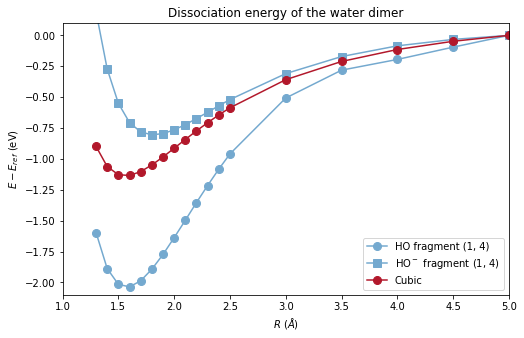

In [17]:
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#74a9cf', '#b2182b']
markers = ['o', 's', 'o']
size = [8]*3

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-2.1, 0.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

**Conclusion:**

While the HO$^-$ fragment calculations have a rather correct agreement with the cubic reference calculation, this is not the case for HO fragment. The latter has a better agreement concerning the equilibrium distance, but the dimer is overbinded by almost 1 eV. Why is that?

## Influence of *nbasis*

To answer that question, let us investigate what happens when the the number of basis functions is increased, in the same manner as in the water dimer case. We will run four setups: one with 2 and 5 basis functions for the hydorgen and oxygen atom, respectively, and another one using 5 and 8 basis functions, both for the neutral and the minus-charged HO.

### Template calculations

Again, we begin by computing the templates, for both types of fragments. Do not forget to add the right occupation block to each input file!

In [18]:
ig_25_yaml = """
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0"""

ig_58_yaml = """
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
     2p: [0., 0., 0.]
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0
     3p: [0., 0., 0.]"""

#### HO templates

In [19]:
# Go to the templates folder
os.chdir(templates_path)

# Run the template of the oh molecule with 2 (resp. 5) 
# support functions for the hydrogen (resp. oxygen) atom
run_bigdft(ho_yaml(On=5, Hn=2)+ig_25_yaml, ho_xyz, prefix="ho_25")

# Run the template of the oh molecule with 5 (resp. 8) 
# support functions for the hydrogen (resp. oxygen) atom
run_bigdft(ho_yaml(On=8, Hn=5)+ig_58_yaml, ho_xyz, prefix="ho_58")

Logfile log-ho_25.yaml already exists!
Logfile log-ho_58.yaml already exists!


#### HO- templates

In [20]:
# Run the template of the oh molecule with 2 (resp. 5) 
# support functions for the hydrogen (resp. oxygen) atom
run_bigdft(ho_yaml(On=5, Hn=2, charged=True)+ig_25_yaml, ho_xyz, prefix="ho-_25")

# Run the template of the oh molecule with 5 (resp. 8) 
# support functions for the hydrogen (resp. oxygen) atom
run_bigdft(ho_yaml(On=8, Hn=5, charged=True)+ig_58_yaml, ho_xyz, prefix="ho-_58")

Logfile log-ho-_25.yaml already exists!
Logfile log-ho-_58.yaml already exists!


### Fragment calculations

#### HO templates

In [21]:
# Go to the dimer folder
os.chdir(dimer_path)

# Run the first setup
yaml_25 = dimer_yaml(frag_names=["h2o_25", "ho_25"], Hn=2, On=5)+ig_25_yaml
run_setup("ho_2-5", dists, yaml_25, dimer_xyz, templates_dir=templates_path)

# Run the second setup
yaml_58 = dimer_yaml(frag_names=["h2o_58", "ho_58"], Hn=5, On=8)+ig_58_yaml
run_setup("ho_5-8", dists, yaml_58, dimer_xyz, templates_dir=templates_path)

ho_2-5; dist=1.3
Logfile log-dimer.yaml already exists!
ho_2-5; dist=1.4
Logfile log-dimer.yaml already exists!
ho_2-5; dist=1.5
Logfile log-dimer.yaml already exists!
ho_2-5; dist=1.6
Logfile log-dimer.yaml already exists!
ho_2-5; dist=1.7
Logfile log-dimer.yaml already exists!
ho_2-5; dist=1.8
Logfile log-dimer.yaml already exists!
ho_2-5; dist=1.9
Logfile log-dimer.yaml already exists!
ho_2-5; dist=2.0
Logfile log-dimer.yaml already exists!
ho_2-5; dist=2.1
Logfile log-dimer.yaml already exists!
ho_2-5; dist=2.2
Logfile log-dimer.yaml already exists!
ho_2-5; dist=2.3
Logfile log-dimer.yaml already exists!
ho_2-5; dist=2.4
Logfile log-dimer.yaml already exists!
ho_2-5; dist=2.5
Logfile log-dimer.yaml already exists!
ho_2-5; dist=3.0
Logfile log-dimer.yaml already exists!
ho_2-5; dist=3.5
Logfile log-dimer.yaml already exists!
ho_2-5; dist=4.0
Logfile log-dimer.yaml already exists!
ho_2-5; dist=4.5
Logfile log-dimer.yaml already exists!
ho_2-5; dist=5.0
Logfile log-dimer.yaml already 

#### HO$^-$ templates

In [22]:
# Run the first setup
yaml_25 = dimer_yaml(frag_names=["h2o_25", "ho-_25"], Hn=2, On=5)+ig_25_yaml
run_setup("ho-_2-5", dists, yaml_25, dimer_xyz, templates_dir=templates_path)

# Run the second setup
yaml_58 = dimer_yaml(frag_names=["h2o_58", "ho-_58"], Hn=5, On=8)+ig_58_yaml
run_setup("ho-_5-8", dists, yaml_58, dimer_xyz, templates_dir=templates_path)

ho-_2-5; dist=1.3
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=1.4
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=1.5
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=1.6
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=1.7
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=1.8
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=1.9
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=2.0
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=2.1
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=2.2
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=2.3
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=2.4
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=2.5
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=3.0
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=3.5
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=4.0
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=4.5
Logfile log-dimer.yaml already exists!
ho-_2-5; dist=5.0
Logfile log-d

### Dissociation curves

The data to plot the dissociation curves is then collected:

In [23]:
setups = ["ho_2-5", "ho-_2-5", "ho_5-8", "ho-_5-8"]
legends = ['HO fragment (2, 5)', 'HO$^-$ fragment (2, 5)', \
           'HO fragment (5, 8)', 'HO$^-$ fragment (5, 8)']
new_curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

HO fragment (2, 5)
HO$^-$ fragment (2, 5)
HO fragment (5, 8)
HO$^-$ fragment (5, 8)


The plot is finally done using matplotlib:

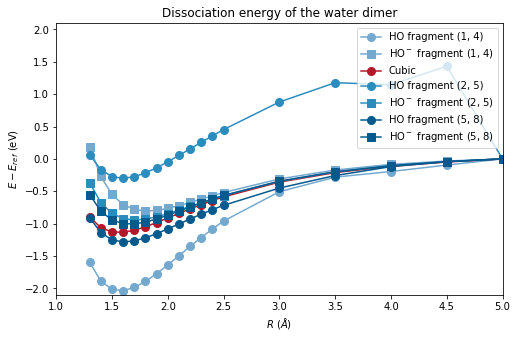

In [24]:
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf']*2 + ['#b2182b'] + ['#2b8cbe']*2 + ['#045a8d']*2
markers = ['o', 's', 'o'] + ['o', 's']*2
size = [8]*len(colors)

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves+new_curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-2.1, 2.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

It appears that both HO and HO$^-$ fragment show different behaviours, so that this plot is not easy to read. Let us then compare the HO$^-$ fragment first:

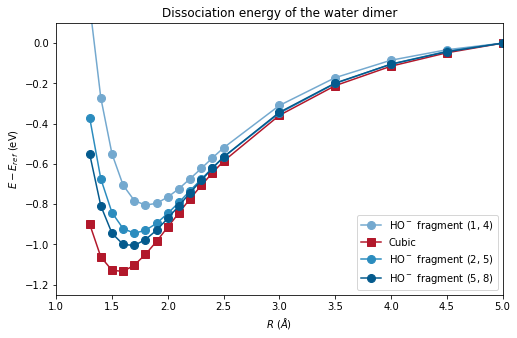

In [25]:
# Lists of markers and colors (for matplotlib)
colors_HOm = ['#74a9cf'] + ['#b2182b'] + ['#2b8cbe'] + ['#045a8d']
markers_HOm = ['o', 's', 'o', 'o']
size_HOm = [8]*len(colors_HOm)

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves[1:]+new_curves[1::2]):
    plt.plot(data['distances'], data['energies'], marker=markers_HOm[i], 
             ls='-', label=data['legend'], color=colors_HOm[i], ms=size_HOm[i])
plt.ylim([-1.25, 0.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

There is a convergence as the nbasis values are increased, in the same manner as in the water dimer case: the basis set superposition error decreases, and the dissociation curves tend to the cubic reference.

The situation is rather different for the HO fragment:

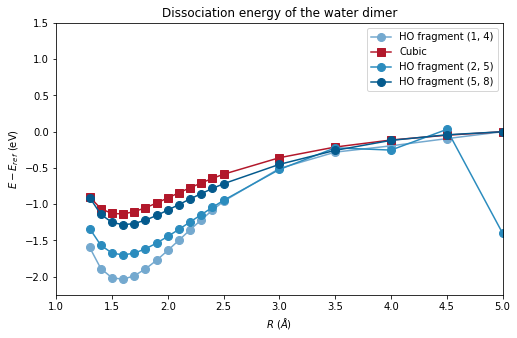

In [26]:
# Lists of markers and colors (for matplotlib)
colors_HO_m = ['#74a9cf'] + ['#b2182b'] + ['#2b8cbe'] + ['#045a8d']
markers_HO_m = ['o', 's', 'o', 'o']
size_HO_m = [8] * len(colors_HO_m)

# Correction of the (2, 5) reference energy
ref = 1.4
if new_curves[0]['energies'][-1] != -ref:
    new_curves[0]['energies'] = [en - 1.4 for en in new_curves[0]['energies']]

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves[::2]+new_curves[::2]):
    plt.plot(data['distances'], data['energies'], marker=markers_HO_m[i], 
             ls='-', label=data['legend'], color=colors_HO_m[i], ms=size_HO_m[i])
plt.ylim([-2.25, 1.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

There is a fluctuation at large distance for the HO fragment when the nbasis parameter is low, this fluctuation (whose reason is currently undefined) being dramatic for the (2, 5) case. The reference energy being wrong, we manually correct it before plotting.

From this set of calculations, one observes that the use of the HO fragment tends to overbind the dimer, while increasing the nbasis reduces this overbinding and gives rise to a small increase of the equilibrium distance. **Why is that?**

**Other plots**

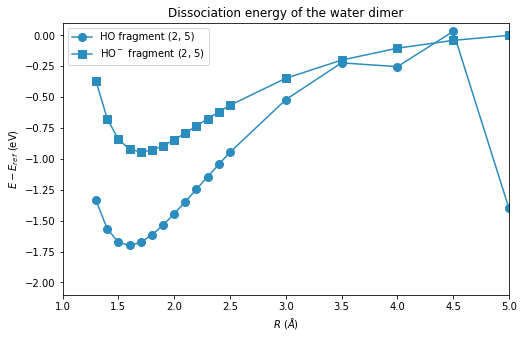

In [27]:
# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(new_curves[:2]):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[3+i], ms=size[i])
plt.ylim([-2.1, 0.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

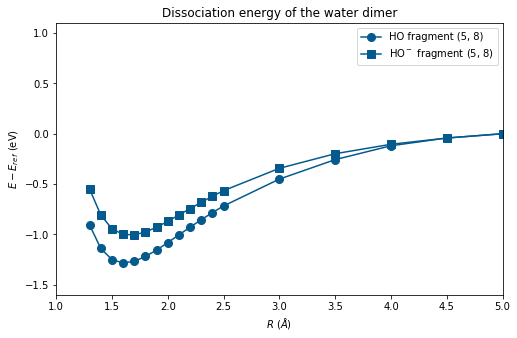

In [28]:
# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(new_curves[2:]):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[5+i], ms=size[i])
plt.ylim([-1.6, 1.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

## Create archives

To avoid running all calculations when running this notebook again, we create two archives as tar files:

* one containing all logs _log-dimer*_ and all input files *dimer.yaml* and positions *dimer.xyz* for each setup,

* another one containing all data for the templates (output and input files _template*xyz_, _template*xyz_ plus the folders _data-template*_)

In [29]:
# Go back to the starting folder, with both templates and dimer folders
os.chdir(start_path)

# List the setups to send to the setup archive
setups = ['ho-_1-4', 'ho_1-4', 'ho-_2-5', 'ho_2-5', \
          'ho-_5-8', 'ho_5-8', 'cubic']

# Create an archive with logs and input files for each setup
if not os.path.exists(tarname):
    tar = tarfile.open(tarname, "w:bz2")
    for setup in setups:
        logfiles = find_files(dimer_folder+"/"+setup+"/dimer_*/log-dimer*.yaml")
        input_files = find_files(dimer_folder+"/"+setup+"/dimer_*/dimer.yaml")
        posinp_files = find_files(dimer_folder+"/"+setup+"/dimer_*/dimer.xyz")
        for name in logfiles + input_files + posinp_files:
            tar.add(name)
    tar.close()
    print("Creation of a tar file with all log files: {}".format(tarname))
else:
    print("No creation of tarfile {} because it already exists!".format(tarname))

# List the templates to send to the template archive
templates = ['h2o', 'h2o_25', 'h2o_58', 'ho', 'ho_25', 'ho_58', \
             'ho-', 'ho-_25', 'ho-_58']

# Create a second archive with templates data
if not os.path.exists(tartemplate):
    tar = tarfile.open(tartemplate, "w:bz2")
    for template in templates:
        data_folders = [templates_folder+'/data-'+template+"/"+f 
                        for f in find_files(templates_folder+'/data-'+template)]
        logfiles = find_files(templates_folder+"/log-"+template+".yaml")
        input_files = find_files(templates_folder+"/"+template+".yaml")
        posinp_files = find_files(templates_folder+"/"+template+".xyz")
        for name in data_folders + logfiles + input_files + posinp_files:
            tar.add(name)
    tar.close()
    print("Creation of a tar file with all log files: {}".format(tartemplate))
else:
    print("No creation of tarfile {} because it already exists!".format(tartemplate))

No creation of tarfile H2O_HO-.tgz because it already exists!
No creation of tarfile templates_H2O_HO-.tgz because it already exists!
